In [1]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from keras.models import Model
from sklearn.ensemble import VotingClassifier
from keras.layers import Input, Dense
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

csv_path = 'Kepler_Objects_of_interest.csv'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
warnings.filterwarnings("ignore", category=UserWarning)



2024-11-11 16:37:48.282902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

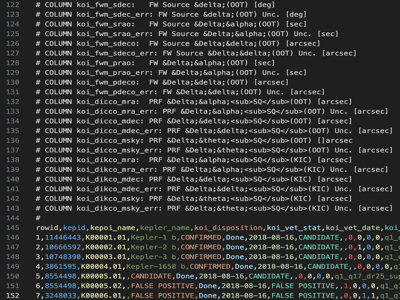

In [45]:
Image("Dataset_image_resized.png")

### Data set의 불필요 부분 제거

In [46]:
file_path = 'q1_q17_dr25_sup_koi_2024.11.08_01.40.12.csv'
csv_path = 'Kepler_Objects_of_interest.csv'

data = pd.read_csv(file_path, skiprows=144, on_bad_lines='skip')

data.to_csv(csv_path, index=False)

print(f"새로운 파일로 저장되었습니다: {csv_path}")

새로운 파일로 저장되었습니다: Kepler_Objects_of_interest.csv


### 100%인 결측치 확인 & 제거

In [47]:
# 데이터 불러오기
data = pd.read_csv(csv_path)

# 모든 행 출력 옵션 설정
pd.options.display.max_rows = None

# 결측치 비율 확인
missing_data = data.isnull().mean() * 100

# 결측치가 100%인 열 필터링하여 출력
missing_data_100 = missing_data[missing_data == 100]
print("결측치가 100%인 열:", missing_data_100)

# 결측치가 100%가 아닌 열만 선택하여 클린된 데이터로 저장
data_cleaned = data.loc[:, missing_data < 100]
data_cleaned.to_csv('clean_Kepler.csv', index=False)
print("결측치 제거 완료")

# 클린된 데이터 다시 불러오기
clean_csv = 'clean_Kepler.csv'
data_cleaned = pd.read_csv(clean_csv)

# 결측치가 제거된 후의 비율 확인
data_cleaned_missing_data = data_cleaned.isnull().mean() * 100
print("\n결측치가 제거된 후의 결측치 비율:\n", data_cleaned_missing_data)

# 남아 있는 결측치가 있는 열만 필터링하여 출력
remaining_missing = data_cleaned_missing_data[data_cleaned_missing_data > 0]
print("\n남아 있는 결측치가 있는 열과 그 비율:\n", remaining_missing)

# 모든 열에 결측치가 있는지 확인
data_missing_check = data_cleaned.isnull().sum().sum()
if data_missing_check == 0:
    print("\n모든 100% 결측치가 제거되었습니다.")
else:
    print(f"\n남아 있는 결측치의 총 개수: {data_missing_check}")

# 각 클래스에 따른 데이터 분포 확인
class_distribution = data_cleaned['koi_disposition'].value_counts(normalize=True) * 100
print("\n클래스 분포:\n", class_distribution)


결측치가 100%인 열: koi_score             100.0
koi_comment           100.0
koi_eccen             100.0
koi_eccen_err1        100.0
koi_eccen_err2        100.0
koi_longp             100.0
koi_longp_err1        100.0
koi_longp_err2        100.0
koi_impact            100.0
koi_impact_err1       100.0
koi_impact_err2       100.0
koi_duration          100.0
koi_duration_err1     100.0
koi_duration_err2     100.0
koi_ingress           100.0
koi_ingress_err1      100.0
koi_ingress_err2      100.0
koi_depth             100.0
koi_depth_err1        100.0
koi_depth_err2        100.0
koi_ror               100.0
koi_ror_err1          100.0
koi_ror_err2          100.0
koi_srho              100.0
koi_srho_err1         100.0
koi_srho_err2         100.0
koi_fittype           100.0
koi_prad              100.0
koi_prad_err1         100.0
koi_prad_err2         100.0
koi_sma               100.0
koi_sma_err1          100.0
koi_sma_err2          100.0
koi_incl              100.0
koi_incl_err1         100.0
koi_in

# Dataset 분포

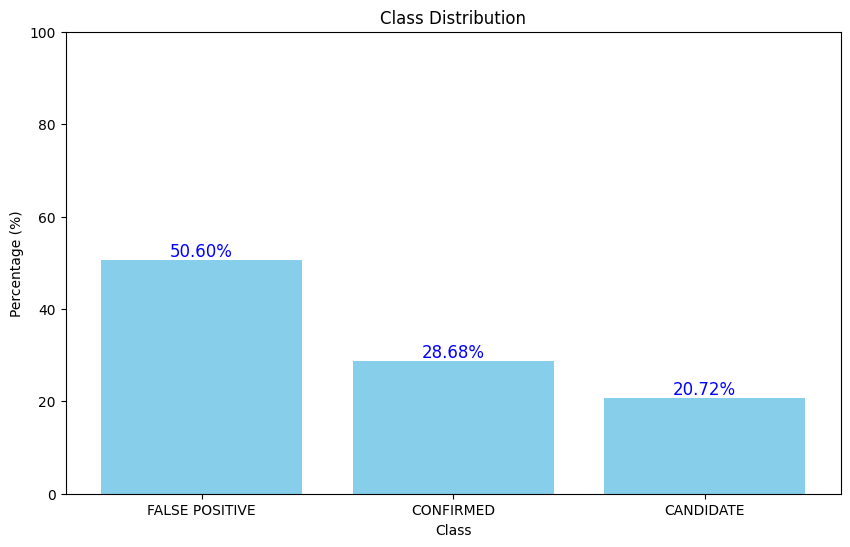

In [48]:
# CSV 파일 읽기
data = pd.read_csv(clean_csv)

# 클래스 비율 계산 
class_column = 'koi_disposition'
class_counts = data[class_column].value_counts(normalize=True) * 100  # 비율로 변환

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

# 각 막대에 비율 값 추가
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.2f}%', ha='center', va='bottom', fontsize=12, color='blue')

# 그래프 설정
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Y축 범위를 0-100%로 설정
plt.show()


## 데이터 전처리

In [49]:
# 데이터 불러오기
data = pd.read_csv(clean_csv)

# 데이터 전처리 
selected_features = [
    'koi_period', 'koi_period_err1', 'koi_period_err2',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_time0', 'koi_time0_err1', 'koi_time0_err2'
]

# 실제로 데이터프레임에 존재하는 열만 선택 및 확인
existing_features = [feature for feature in selected_features if feature in data.columns]

# 존재하는 열 출력
print("선택된 존재하는 열:", existing_features)

# 행성 여부 데이터 필터링 (CONFIRMED와 FALSE POSITIVE만 사용)
data_filtered = data[data['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]

# 특성 데이터와 타겟 데이터 분리
X = data_filtered[existing_features]
y = data_filtered['koi_disposition'].astype('category').cat.codes


선택된 존재하는 열: ['koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2']


In [50]:
# 최적의 K를 찾기 위한 Pipeline 설정
pipeline = Pipeline([
    ('imputer', KNNImputer()),  # 최적의 K 값을 찾을 KNN 임퓨터
    ('classifier', LogisticRegression(max_iter=1000))
])

# RandomizedSearchCV 파라미터 분포
param_distributions = {
    'imputer__n_neighbors': np.arange(5, 51)  
}

# F1 스코어를 기준으로 최적의 K값을 찾기 위한 설정
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,
    random_state=42
)

# 데이터를 사용해 최적의 K 찾기
random_search.fit(X, y)  # X와 y는 원래 데이터셋 (결측치를 포함한 상태)

# 최적의 K값과 해당 F1-score 출력
best_k = random_search.best_params_['imputer__n_neighbors']
best_f1_score = random_search.best_score_
print(f"Best K: {best_k}, F1 Score: {best_f1_score}")


Best K: 46, F1 Score: 0.8859527502676301


In [51]:
# KNN을 사용하여 결측값 대체 (최적의 K값 사용)
knn_imputer = KNNImputer(n_neighbors=best_k)
X = knn_imputer.fit_transform(X)

# 오토인코더 모델 구성
input_dim = X.shape[1]
encoding_dim = int(input_dim / 2)
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 오토인코더 모델 컴파일 및 학습
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(X, X, epochs=100, batch_size=16, shuffle=True, verbose=1, callbacks=[early_stopping])

# 오토인코더를 사용하여 결측치 대체
X_imputed = autoencoder.predict(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Epoch 1/100


2024-11-11 15:23:17.630047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-11 15:23:17.684466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


474/474 [==============================] - 5s 9ms/step - loss: 710544982016.0000
Epoch 2/100
474/474 [==============================] - 4s 9ms/step - loss: 15428427776.0000
Epoch 3/100
474/474 [==============================] - 4s 9ms/step - loss: 2944480.0000
Epoch 4/100
474/474 [==============================] - 4s 9ms/step - loss: 1875.6433
Epoch 5/100
474/474 [==============================] - 4s 9ms/step - loss: 1880.6708
Epoch 6/100
474/474 [==============================] - 4s 9ms/step - loss: 1880.6869
Epoch 7/100
474/474 [==============================] - 4s 9ms/step - loss: 1897.8420
Epoch 8/100
474/474 [==============================] - 4s 9ms/step - loss: 1916.4868
Epoch 9/100
 51/237 [=====>........................] - ETA: 0s

2024-11-11 15:23:56.729853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 1s 3ms/step


In [52]:
# 클래스 가중치 계산
classes = np.unique(y_train_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_resampled)
class_weights_dict = dict(zip(classes, class_weights))

# LightGBM 하이퍼파라미터 설정
lgbm_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [7, 10, 15],
    'learning_rate': [0.3, 0.5, 0.1],  
    'num_leaves': [63, 127, 255],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost 하이퍼파라미터 설정
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.3, 0.5, 0.1], 
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# LightGBM 모델 설정 시 가중치 반영
lgbm = LGBMClassifier(class_weight=class_weights_dict, force_row_wise=True, verbosity=-1)

# XGBoost 모델 설정 시 가중치 반영
xgb = XGBClassifier(scale_pos_weight=class_weights_dict[1], eval_metric='mlogloss', tree_method="hist", verbosity=0)

# 하이퍼파라미터 최적화 진행 - LightGBM
cv = StratifiedKFold(n_splits=10)
lgbm_search = RandomizedSearchCV(
    lgbm, lgbm_param_grid, cv=cv, scoring='balanced_accuracy',
    n_iter=20, random_state=42, n_jobs=-1, verbose=2  
)
lgbm_search.fit(X_train_resampled, y_train_resampled)
best_lgbm = lgbm_search.best_estimator_

# 하이퍼파라미터 최적화 진행 - XGBoost
xgb_search = RandomizedSearchCV(
    xgb, xgb_param_grid, cv=cv, scoring='balanced_accuracy',
    n_iter=20, random_state=42, n_jobs=-1, verbose=2  
)
xgb_search.fit(X_train_resampled, y_train_resampled)
best_xgb = xgb_search.best_estimator_


# LightGBM 및 XGBoost 모델 저장
joblib.dump(best_lgbm, 'best_lgbm_model_best.joblib')
joblib.dump(best_xgb, 'best_xgb_model_best.joblib')

print("Save")



Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  32.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  33.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  33.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  33.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  34.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time=  34.5s
[CV] END colsample_

In [53]:
# 저장된 모델 불러오기
lgbm_model_path = 'best_lgbm_model_best.joblib'
xgb_model_path = 'best_xgb_model_best.joblib'

best_lgbm = joblib.load(lgbm_model_path)
best_xgb = joblib.load(xgb_model_path)

# 앙상블 모델 구성
ensemble_model = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    voting='soft', weights=[1, 2]
)

# 앙상블 모델 학습 
ensemble_model.fit(X_train_resampled, y_train_resampled)

# 앙상블 모델 저장
joblib.dump(ensemble_model, 'best_ensemble_model.joblib')
print("앙상블 모델 저장 완료")


앙상블 모델 저장 완료


X_test 크기: (1517, 9), y_test 크기: (1517,)
분류 성능 평가:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       549
           1       0.98      0.96      0.97       968

    accuracy                           0.96      1517
   macro avg       0.95      0.96      0.96      1517
weighted avg       0.96      0.96      0.96      1517



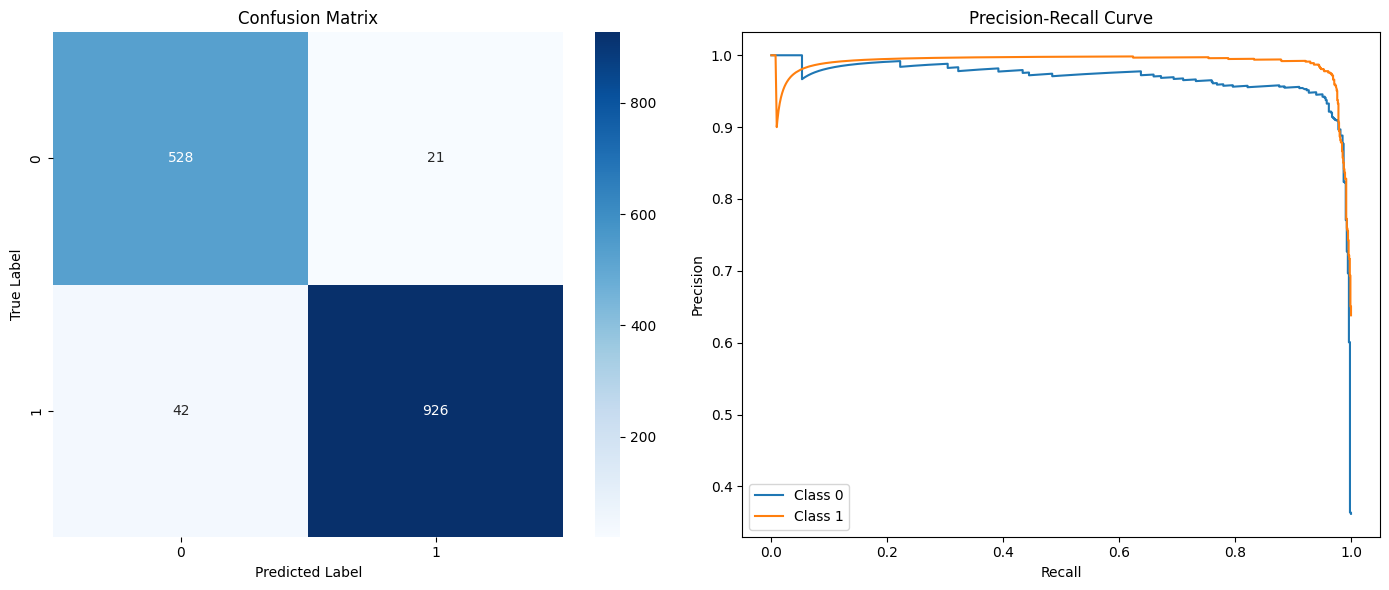

In [56]:
# 저장된 앙상블 모델 불러오기
ensemble_model_path = 'best_ensemble_model.joblib'
ensemble_model = joblib.load(ensemble_model_path)

# 테스트 데이터와 타겟 데이터 크기 확인
X_test = X_test[:len(y_test)]  # y_test와 크기 맞추기
print(f"X_test 크기: {X_test.shape}, y_test 크기: {y_test.shape}")

# 모델 예측
y_pred = ensemble_model.predict(X_test)
print("분류 성능 평가:\n", classification_report(y_test, y_pred))

# 혼동 행렬 생성 및 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 6))

# 혼동 행렬 히트맵
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ensemble_model.classes_, yticklabels=ensemble_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Precision-Recall Curve
y_test_binary = pd.get_dummies(y_test, drop_first=False)  # 각 클래스별로 이진화
y_pred_proba = ensemble_model.predict_proba(X_test)  # 예측 확률 계산

plt.subplot(1, 2, 2)
for i in range(y_test_binary.shape[1]):  # 실제로 존재하는 클래스의 개수만큼 반복
    precision, recall, _ = precision_recall_curve(y_test_binary.iloc[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {ensemble_model.classes_[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


### model을 사용해 CANDIDATE Data 중 CONFIRMED될 확률이 0.9이상

In [55]:
# 저장된 앙상블 모델 불러오기
ensemble_model_path = 'best_ensemble_model.joblib'
ensemble_model = joblib.load(ensemble_model_path)

# 특성 선택 및 데이터 전처리
selected_features = [
    'koi_period', 'koi_period_err1', 'koi_period_err2',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_time0', 'koi_time0_err1', 'koi_time0_err2'
]

# 테스트 데이터 전처리
existing_features = [feature for feature in selected_features if feature in data.columns]
X_test_original = data[existing_features].copy()  

# CANDIDATE 데이터 필터링 및 예측 수행
data_candidate = data[data['koi_disposition'] == 'CANDIDATE']
X_candidate = data_candidate[existing_features].copy()
X_candidate = X_candidate.fillna(0)

# CANDIDATE 데이터에 대해 예측 수행
y_pred_proba_ensemble = ensemble_model.predict_proba(X_candidate)

# CONFIRMED 확률이 가장 높은 샘플 찾기
max_prob_index = y_pred_proba_ensemble[:, 1].argmax()
max_prob_sample = data_candidate.iloc[max_prob_index]
max_prob = y_pred_proba_ensemble[max_prob_index][1]

# CONFIRMED 확률이 0.9 이상인 샘플 찾기
confirmed_mask = y_pred_proba_ensemble[:, 1] > 0.9
confirmed_samples = data_candidate[confirmed_mask]
confirmed_probs = y_pred_proba_ensemble[confirmed_mask, 1]

# 예측 결과 출력
print(f"CONFIRMED 확률이 가장 높은 CANDIDATE 샘플:\n{max_prob_sample}")
print(f"\n예측 확률: CONFIRMED: {max_prob:.2f}, FALSE POSITIVE: {y_pred_proba_ensemble[max_prob_index][0]:.2f}")

# CONFIRMED 확률이 0.9 이상인 샘플 개수 및 각 샘플 출력
print(f"\nCONFIRMED 확률이 0.9 이상인 샘플 개수: {confirmed_samples.shape[0]}")
for i, (index, sample) in enumerate(confirmed_samples.iterrows()):
    print(f"\n샘플 {i + 1} (Index {index}):")
    print(sample)
    print(f"CONFIRMED 확률: {confirmed_probs[i]:.2f}")

# 예측에 사용된 특성 값 출력
print("\n예측에 사용된 특성 값:")
for feature in existing_features:
    print(f"{feature}: {max_prob_sample[feature]}")


CONFIRMED 확률이 가장 높은 CANDIDATE 샘플:
rowid                               6455
kepid                            6197658
kepoi_name                     K05247.01
kepler_name                          NaN
koi_disposition                CANDIDATE
koi_vet_stat                        Done
koi_vet_date                  2018-08-16
koi_pdisposition               CANDIDATE
koi_fpflag_nt                          0
koi_fpflag_ss                          0
koi_fpflag_co                          0
koi_fpflag_ec                          0
koi_disp_prov        q1_q17_dr25_sup_koi
koi_period                      282.0309
koi_period_err1                   0.1416
koi_period_err2                  -0.1416
koi_time0bk                     162.5448
koi_time0bk_err1                  0.0794
koi_time0bk_err2                 -0.0794
koi_time0                    2454995.545
koi_time0_err1                    0.0794
koi_time0_err2                   -0.0794
koi_parm_prov        q1_q17_dr25_sup_koi
koi_count              